In [1]:
import numpy as np
import sympy as sym
import control as ctrl
import matplotlib.pyplot as plt

from get_kr import get_kr

In [2]:
#%% Paso 1. Obtenemos los puntos de equilibrio
H,r,u,k,a,L,c,b,d  = sym.symbols('H,r,u,k,a,L,c,b,d')

# Sistema no lineal
eqn1 = (r + u)*H*(1 - H/k)- (a*H*L)/(c + H) # población de liebres
eqn2 = b*((a*H*L)/(c + H)) - d*L # población de linces

E = sym.solve((eqn1,eqn2),(H,L))
print('(He, Le) := ', E)

# Punto de equilibrio de interés
He_Le = sym.lambdify([a,b,c,d,k,r,u], E[2])

#%% Paso 2. Creamos la jacobiana del sistema
J = sym.Matrix([[sym.diff(eqn1,H), sym.diff(eqn1,L)],
                [sym.diff(eqn2,H), sym.diff(eqn2,L)]])

B = sym.Array([[sym.diff(eqn1,u)],
                [sym.diff(eqn2,u)]])

B = sym.lambdify([k,H], B)

C = np.array([[0.0, 1.0]])

D = 0

print("J := ", J)

J = sym.lambdify([a,b,c,d,k,r,u,H,L], J)

(He, Le) :=  [(0, 0), (k, 0), (c*d/(a*b - d), -b*c*(r + u)*(-a*b*k + c*d + d*k)/(k*(a*b - d)**2))]
J :=  Matrix([[H*L*a/(H + c)**2 - H*(r + u)/k - L*a/(H + c) + (r + u)*(-H/k + 1), -H*a/(H + c)], [-H*L*a*b/(H + c)**2 + L*a*b/(H + c), H*a*b/(H + c) - d]])


In [3]:
#%% Paso 3. Linealizamos en torno a los puntos de equilibrio
# Parametros del sistema
a = 3.2 # describe cómo disminuyen las liebres en función de la población de linces
b = 0.6 # coeficiente de crecimiento de los linces
c = 50 # tasa de consumo de presas para una población baja de liebres
d = 0.56 # tasa de mortalidad de los linces
k = 125 # población máxima de liebres (en ausencia de linces)
r = 1.6 # tasa de crecimiento de las liebres
u = 0 # fuente de alimento para las liebres

E = He_Le(a,b,c,d,k,r,u)
print('(He, Le) :=', E)

A = J(a,b,c,d,k,r,u,E[0],E[1])
print('A := ', A)

B = B(k, E[0])
print('B := ', B)

sys_ss = ctrl.ss(A,B,C,0)
print(sys_ss)

print('Eigenvalues: ', np.linalg.eigvals(A))

U = ctrl.ctrb(A, B)
print('Matriz controlabilidad U:= ', U)

if np.linalg.det(U) != 0:
    print('Sistema controlable')
else:
    print('Sistema no controlable')

(He, Le) := (20.588235294117652, 29.480968858131494)
A :=  [[ 0.12627451 -0.93333333]
 [ 0.568       0.        ]]
B :=  [[17.19723183]
 [ 0.        ]]
<StateSpace>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.12627451 -0.93333333]
     [ 0.568       0.        ]]

B = [[17.19723183]
     [ 0.        ]]

C = [[0. 1.]]

D = [[0.]]

Eigenvalues:  [0.06313725+0.72535992j 0.06313725-0.72535992j]
Matriz controlabilidad U:=  [[17.19723183  2.17157202]
 [ 0.          9.76802768]]
Sistema controlable


In [4]:
#%% Paso 4. Polos deseados
eig_d = np.array([-0.1, -0.2])

K = ctrl.place(A, B, eig_d)
print('K:= ', K)

kr = get_kr(sys_ss, K)
print('k_r:= ', kr)

K:=  [[ 0.02478739 -0.0522248 ]]
k_r:=  [[0.0020475]]


In [5]:
#%% Paso 5. Simular el sistema
# Condiciones iniciales
H0 = 15 # población inicial de liebres
L0 = 20 # población de linces

Acl = A - B*K
Bcl = kr*B

sys_ss_cl_K = ctrl.ss(Acl, Bcl, C, D)
sys_ss_cl_K

StateSpace(array([[-0.3       , -0.03521127],
       [ 0.568     ,  0.        ]]), array([[0.03521127],
       [0.        ]]), array([[0., 1.]]), array([[0.]]))

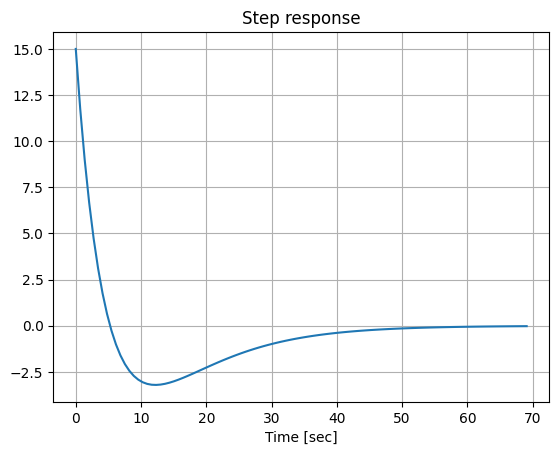

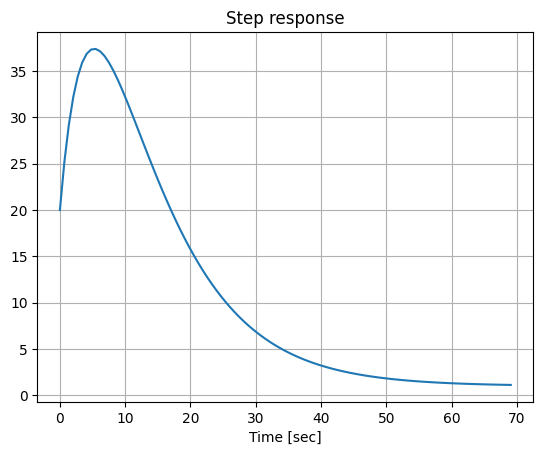

In [11]:
# Respuesta ante una entrada de tipo 'step' para el sistema en lazo cerrado
sys_ss_cl = ctrl.ss(Acl, Bcl, C, 0)
t_cl, yout_cl, x_cl = ctrl.step_response(sys_ss_cl_K, return_x = True, X0=[H0, L0])

plt.figure()
plt.plot(t_cl, x_cl[0,:])
plt.title('Step response')
plt.xlabel('Time [sec]')
plt.grid('minor')
plt.show()

plt.figure()
plt.plot(t_cl, x_cl[1,:])
plt.title('Step response')
plt.xlabel('Time [sec]')
plt.grid('minor')
plt.show()

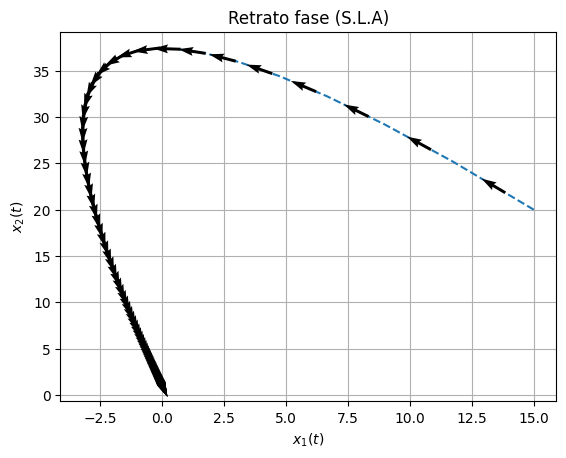

In [12]:
u = np.diff(x_cl[0,:])
v = np.diff(x_cl[1,:])

pos_x = x_cl[0,:][:-1] + u/2
pos_y = x_cl[1,:][:-1] + v/2
norm = np.sqrt(u**2+v**2) 

fig, ax = plt.subplots()
ax.plot(x_cl[0,:], x_cl[1,:], '--')
ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")
ax.set_xlabel('$x_1(t)$')
ax.set_ylabel('$x_2(t)$')
ax.set_title('Retrato fase (S.L.A)')
ax.grid('on')
plt.show()